<a href="https://www.kaggle.com/maulberto3/house-prices-probabilistic-neural-network?scriptVersionId=89513736" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%reset -sf

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

In [3]:
def load_data():
    # Read data
    data_dir = Path("../input/house-prices-advanced-regression-techniques/")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

In [4]:
data_dir = Path("../input/house-prices-advanced-regression-techniques/")
df = pd.read_csv(data_dir / "train.csv", index_col="Id")

df.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [5]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df


In [6]:
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df


In [7]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df


In [8]:
df_train, df_test = load_data()

In [9]:
X_train = df_train.select_dtypes(include='number')
X_train

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,FirstFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,2003,2003,196.0,706.0,0.0,150.0,856.0,856,...,0,61,0,0,0,0,0,2,2008,208500.0
2,80.0,9600,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,...,298,0,0,0,0,0,0,5,2007,181500.0
3,68.0,11250,2001,2002,162.0,486.0,0.0,434.0,920.0,920,...,0,42,0,0,0,0,0,9,2008,223500.0
4,60.0,9550,1915,1970,0.0,216.0,0.0,540.0,756.0,961,...,0,35,272,0,0,0,0,2,2006,140000.0
5,84.0,14260,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,...,192,84,0,0,0,0,0,12,2008,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,62.0,7917,1999,2000,0.0,0.0,0.0,953.0,953.0,953,...,0,40,0,0,0,0,0,8,2007,175000.0
1457,85.0,13175,1978,1988,119.0,790.0,163.0,589.0,1542.0,2073,...,349,0,0,0,0,0,0,2,2010,210000.0
1458,66.0,9042,1941,2006,0.0,275.0,0.0,877.0,1152.0,1188,...,0,60,0,0,0,0,2500,5,2010,266500.0


In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)

X_train.shape

y_train = X_train[:, -1]
X_train = X_train[:, :-1]

X_train.mean(axis=0), X_train.std(axis=0)
y_train.mean(axis=0), y_train.std(axis=0)

(1460, 34)

(array([0.18409996, 0.04308036, 0.71933194, 0.58109589, 0.0644482 ,
        0.07860378, 0.03158027, 0.24282552, 0.17306538, 0.19013922,
        0.16803509, 0.01021769, 0.22258171, 0.14178082, 0.02876712,
        0.5216895 , 0.19143836, 0.35830479, 0.34885845, 0.37648402,
        0.2043379 , 0.75730097, 0.44178082, 0.3335544 , 0.10997027,
        0.08530215, 0.03977194, 0.00671179, 0.031377  , 0.00373835,
        0.00280574, 0.48381071, 0.45393836]),
 array([0.11071064, 0.04663744, 0.21878666, 0.34397225, 0.11291842,
        0.08078346, 0.10940571, 0.18909058, 0.07177661, 0.08867722,
        0.21132151, 0.08497627, 0.0989639 , 0.17291096, 0.11933543,
        0.1835757 , 0.25135657, 0.10193733, 0.07342091, 0.13540305,
        0.21481519, 0.19056325, 0.18676476, 0.15072751, 0.14620287,
        0.1210847 , 0.11068517, 0.05769151, 0.11612149, 0.05442215,
        0.03199697, 0.24570001, 0.33191005]))

(0.20277905275713232, 0.11028369932796486)

In [11]:
from torch.cuda import is_available
DEVI = "cuda" if is_available() else "cpu"
# device = "cpu"
print("==> Device:", DEVI)

from torch import manual_seed
manual_seed(16)
from random import seed
seed(16)

==> Device: cpu


In [12]:
BATCH_SIZE = 64
LR = 0.0005

In [13]:
from torch.distributions import Normal
from torch import nn
from torch import float as pt_float, ones, column_stack, as_tensor

class NET(nn.Module):
    def __init__(self, l1, a1, l2, a2, l3, a3):
        super().__init__()
        
        self.lin1 = nn.Sequential(
            nn.Linear(33, l1),
            nn.Dropout(0.5),
            nn.__getattribute__(a1)())
        
        self.lin2 = nn.Sequential(
            nn.BatchNorm1d(13),
            nn.Linear(13, l2),
            nn.Dropout(0.25),
            nn.__getattribute__(a2)())

        self.lin3 = nn.Sequential(
            nn.BatchNorm1d(79),
            nn.Linear(79, l3),
            nn.Dropout(0.25),
            nn.__getattribute__(a3)())

        self.out1 = nn.Sequential(
            #nn.Flatten(),
            nn.Linear(72, 1))
        
        self.out2= nn.Sequential(
            #nn.Flatten(),
            nn.Linear(72, 1))
        
        self.miu = nn.Sequential(
            self.lin1,
            self.lin2,
            self.lin3,
            self.out1
        )
        
        self.sigma = nn.Sequential(
            self.lin1,
            self.lin2,
            self.lin3,
            self.out2)
        
    def forward(self, x):
        """Forward"""
        return column_stack((self.miu(x), self.sigma(x)))
    
    def count_weights_biases(self):
        return int(sum(p.numel() for p in self.parameters() if p.requires_grad))

In [14]:
from sklearn.metrics import mean_squared_error
from torch import stack
from torch.optim import Adam
from torch.utils.data import DataLoader

# Params
params = {'l1': 13,
  'a1': 'ReLU',
  'l2': 79,
  'a2': 'SELU',
  'l3': 72,
  'a3': 'Softsign'}

# Train
net = NET(**params).eval()
_ = net(ones(5, 33))

# Optimizer
optimizer = Adam(net.parameters(), lr=LR*0.75)

# Train
#X_train, y_train = from_numpy(X_train), from_numpy(y_train)
train_dl = DataLoader(list(zip(X_train, y_train)),
                    batch_size=BATCH_SIZE*2,
                    shuffle=True,
                    num_workers=2,
                    drop_last=True)

for j, epoch in enumerate(range(15)):
    for i, (X, y) in enumerate(train_dl):
        outputs = net(X.to(DEVI, dtype=pt_float))

        loss = [Normal(loc, scale.exp()) for loc, scale in outputs]
        loss = [-normal.log_prob(y_th) for normal, y_th in zip(loss, y)]
        loss = stack(loss).mean()  # nllloss by hand!

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {j+1} | TRAIN {np.sqrt(mean_squared_error( outputs[:, 0].detach(), y )):^5.2f}')

Epoch 1 | TRAIN 0.25 
Epoch 2 | TRAIN 0.14 
Epoch 3 | TRAIN 0.10 
Epoch 4 | TRAIN 0.12 
Epoch 5 | TRAIN 0.09 
Epoch 6 | TRAIN 0.11 
Epoch 7 | TRAIN 0.09 
Epoch 8 | TRAIN 0.07 
Epoch 9 | TRAIN 0.09 
Epoch 10 | TRAIN 0.08 
Epoch 11 | TRAIN 0.08 
Epoch 12 | TRAIN 0.05 
Epoch 13 | TRAIN 0.05 
Epoch 14 | TRAIN 0.06 
Epoch 15 | TRAIN 0.05 


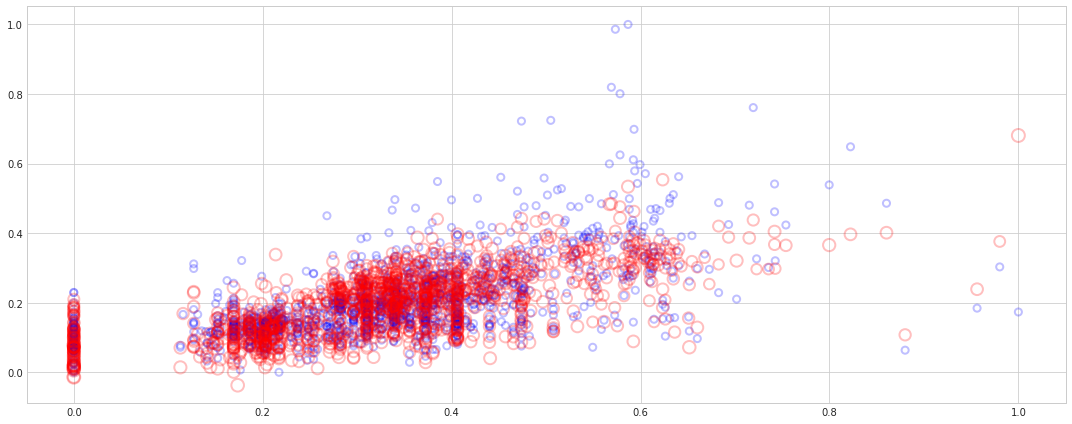

In [15]:
from torch import from_numpy
from random import randint

fig, ax = plt.subplots(figsize=(15,6))

pred = net(from_numpy(X_train).float())
pred[:, 1] = pred[:, 1].exp()
col = randint(0, X_train.shape[1]-1)
_ = ax.scatter(X_train[:, col], y_train, alpha=0.25, facecolor='none', edgecolor='blue', linewidth=2, s=50, label='Y')
_ = ax.scatter(X_train[:, col], pred[:,0].detach(), alpha=0.25, facecolor='none', edgecolor='red', linewidth=2, s=pred[:, 1].detach()*2000, label='Pred')

In [16]:
# In the above graph, you can see the probabilistic neural network in action
# Real values are plotted in blue rings
# Predictions are plotted with red
# But, if you look closely, the standard deviation for each prediction is also estimated
# And that is being plotted as the circumference of the red rings
# Big red rings mean that the prediction is a bit risky, i.e. high standard deviation
# Small red rings means that the prediction is less risky i.e. the net is more confindent with it

# Of course, this is a quick demo and there is room for improvement

In [17]:
# Hope you like it.

# End